# Multivector Transformer for Sentiment Analysis


---
The task chosen is a  NLP classification task about sentiment analysis of reviews. Given in input a text review the model has to give in output if it is a good review or  bad review not.


### Proposed Solution
In order to solve the sentimental analysis task we have decided to implement a classical transformer model with a custom attention function based on geometric algebra operations (see *Geometric Algebra*). Our approach involves building an encoder model capable of producing meaningful embeddings with lower dimensionality. Specifically, we have used geometric algebra operations, particularly geometric products, to leverage the more expressive power of multivectors compared to traditional vectors. By doing so, we aim to push the network towards generating dense representations that capture relevant underlying geometric features (see *Multi Vector Transformer*). This allows us to learn features of a multivector instead of a classic vector for each dense representation of tokens, enhancing the model's ability to generate meaningful embeddings. We then evaluate our new architecture against a standard BERT-like transformer (*Baseline*) to compare the results.

### Evaluation Metrics
The metrics used to evaluate the performance of the baseline and the transformer are the usual metrics used in classification tasks, i.e, accuracy, precision, recall, f1 score. Moreover we have also showed the confusion matrix to give the visual idea of how the model performs (as we can see in Baseline evaluation and Multivector former evaluation cells)

# Initialization


---
### Global Setup
This cell contains all the global variables used to set up the experimental environemnt. Such variables set the model hyperparameters as well as some dataset attributes and flags for debugging and performace monitoring. See the commented code for more detail.

*Note*: the len of the metric vector must be equal to the len of the embedding vectors to ensure the correctness for the dot product.

In [1]:
#@title Imports

# addiclional modules
%pip install -q datasets

# basic
import os
import gc
import sys
import time
from tqdm.notebook import tqdm

# math
import math
import random
import numpy as np

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader, Dataset

# evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# datasets
import copy
from collections import Counter
from datasets import DatasetDict
from datasets import load_dataset
from transformers import BertTokenizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
#@title Global setup

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # cuda debugging

# seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# global variables
already_load = False # this is use to free up ran and vram when needed
already_build = False # this avoid to recreate the algebra every time
timing = True # measure time perfomence of the model
sandbox = True

# important parameter to decide the embedding dimention
alg_pow = 4 # size of algebra

# transformer hyperparameters
embed_dim = 2**alg_pow
num_heads = 4
ff_dim = 256
num_layers = 2
seq_len = 256
gradient_accumulation_steps = 4

# define names to avoid annoyn warnings
model = None
optimizer = None
loss_fn = None

# dataset parameters
small_version = False # True if you want to do debug and use small version of dataset!
batch_size = 64


device: cuda


# Utils


---
This section contains the implementation of some global utiltiy functions used for model training and tensor manipulations.


In [ ]:
#@title General

@torch.jit.script
def fast_einsum(q_einsum, cayley, k_einsum):
    return torch.einsum("...i,ijk,...k->...j", q_einsum, cayley, k_einsum)

# Note this function is copied from: https://github.com/DavidRuhe/clifford-group-equivariant-neural-networks/blob/master/models/modules/utils.py
def unsqueeze_like(tensor: torch.Tensor, like: torch.Tensor, dim=0):
    """
    Unsqueeze last dimensions of tensor to match another tensor's number of dimensions.

    Args:
        tensor (torch.Tensor): tensor to unsqueeze
        like (torch.Tensor): tensor whose dimensions to match
        dim: int: starting dim, default: 0.
    """
    n_unsqueezes = like.ndim - tensor.ndim
    if n_unsqueezes < 0:
        raise ValueError(f"tensor.ndim={tensor.ndim} > like.ndim={like.ndim}")
    elif n_unsqueezes == 0:
        return tensor
    else:
        return tensor[dim * (slice(None),) + (None,) * n_unsqueezes]


In [ ]:
#@title Training

def train_model(
        model,
        dataloader,
        optimizer,
        loss_fn,
        epochs=1,
        device='cpu',
        loss_trend=[],
        set_mask=False,
        mem_step=False,
        timing=False,
):

    print("Training model...")
    training_loop = tqdm(range(epochs), leave=True)
    model.train()
    for epoch, idx in enumerate(training_loop):

        start = time.time()
        total_loss = 0
        for step, batch in  enumerate(dataloader):
            # print(f"batch input ids -> {type(batch['input_ids'])}")
            # print(f"batch input ids -> {(batch['input_ids'])}")
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            optimizer.zero_grad()
            if set_mask:
                logits = model(input_ids, mask)
            else:
                logits = model(input_ids)
            loss = loss_fn(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if mem_step and (step + 1) % mem_step == 0:
                del input_ids
                del labels
                del logits
                del loss
                gc.collect()
                torch.cuda.empty_cache()
                gc.collect()

            if mem_step and step % 25 == 0:
                training_loop.set_postfix({'perc': str(int((step / len(dataloader))*100))+ '%'})

        epoch_loss = total_loss / len(dataloader)
        loss_trend.append(epoch_loss)
        training_loop.set_description(f"Loss: {epoch_loss:.4f}")
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")
        end = time.time()
        if timing:
            # print(f"average time for batch {model.timing:.4f} seconds")
            print(f"average time for batch {np.average(np.asarray(model.timing)):.4f} seconds")
            model.timing = []
            print(f"epoch took {end - start:.4f} seconds")

        # free up memory
        try:
            del input_ids
            del labels
            del logits
            del loss
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
        except:
            pass


In [ ]:
#@title Evaluation

def evaluation(
        model,
        test_dataloader,
        loss_fn,
        device='cpu',
        cm_plot=True
):
    print("Evaluating model...")
    model.eval()
    test_loss = 0

    with torch.no_grad():
        all_predictions = torch.tensor([])
        all_labels = torch.tensor([])

        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label']
            predictions = model(input_ids).to('cpu')
            predictions = torch.softmax(predictions, dim=1)
            all_predictions = torch.cat((all_predictions, predictions), dim=0)
            all_labels = torch.cat((all_labels, labels),dim=0)
            loss = loss_fn(predictions, labels)
            test_loss += loss.item()

        test_loss /= len(test_dataloader)
        print(f"Test Loss: {test_loss}")

        all_predictions = torch.argmax(all_predictions, dim=1)
        true_labels = all_labels.numpy().astype(np.int64)
        predicted_labels = all_predictions.numpy()
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1}")

        if cm_plot:
            print("\nConfusion Matrix:\n")
            # all_predictions = all_predictions.to('cpu')
            # all_labels = all_labels.type(torch.int64).numpy()
            # all_preds = torch.tensor([int(torch.argmax(elem)) for elem in all_predictions])
            cm = confusion_matrix(all_labels, all_predictions)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            ConfusionMatrixDisplay(cm).plot()

# Dataset

---

### Dataset Description
The dataset is imdb (internet movie database) taken from Huggingface ( [IMDB link](https://huggingface.co/datasets/stanfordnlp/imdb)). It’s made up of 100.000 reviews,we have used 25.000 to train our model and another 25.000 are used for the test. \\
The labels are 0 for negative review and 1 for good review, and about their distribution as we can see from the dataset analysis cell the distribution of the labels are quite balanced.



In [ ]:
#@title Data

# load pre-trained tokenizer (BERT as an example)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize mapping dataset
def preprocess_data(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=seq_len)

# get the vocab size form the dataset
vocab_size = tokenizer.vocab_size

# load IMDB dataset from Hugging Face's datasets library
dataset = load_dataset('imdb')

# remove unsupervised split
small_dataset = DatasetDict({
    'train':dataset['train'],
    'test':dataset['test']
})
dataset = small_dataset


if small_version:
    # reduce dataset size for test
    small_train = dataset['train'].shuffle(seed=42).select(range(1000))
    small_test = dataset['test'].shuffle(seed=42).select(range(1000))

    small_dataset = DatasetDict({
        'train':small_train,
        'test':small_test
    })
    dataset = small_dataset
    # print(small_dataset)

# apply preprocessing to the ENTIRE dataset
tokenized_datasets = dataset.map(preprocess_data, batched=True)

# set format for pytorch tensors
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# split dataset into train and test
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

# sreate DataLoader for train and test sets
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=batch_size)
print("Dataset loaded!")

Dataset loaded!


IMDB: 
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})

sentence lenght: 256
number of train batches: 391
number of test batches: 391

max sequence lenght is: 256
average sequence lenght is: 256.0

label shape --> torch.Size([64])
input_ids shape --> torch.Size([64, 256])
attention_mask shape --> torch.Size([64, 256])



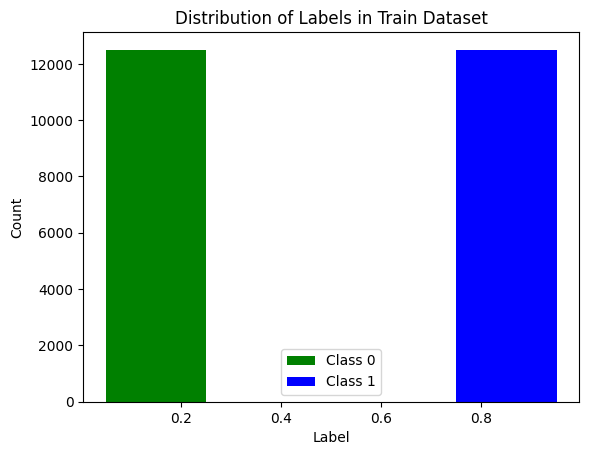

In [ ]:
#@title Dataset analysis

print(f"IMDB: \n{train_dataset}")
print()

print(f"sentence lenght: {len(train_dataset[0]['input_ids'])}")
print(f"number of train batches: {len(train_dataloader)}")
print(f"number of test batches: {len(test_dataloader)}")

print()
max_seq_length = 0
acc = 0
count = 0
for elem in train_dataset:
  l = len(elem['input_ids'])
  acc += l
  count += 1
  if l > max_seq_length:
    max_seq_length = l
print(f"max sequence lenght is: {max_seq_length}")
print(f"average sequence lenght is: {acc / count}")

print()
for elem in train_dataloader:
    for key in elem.keys():
        print(f"{key} shape --> {elem[key].shape}")
    break

print()
labels = train_dataset['label'].numpy()
class_0 = labels[labels == 0]
class_1 = labels[labels == 1]
plt.hist([class_0, class_1], bins=2, color=['green', 'blue'], label=['Class 0', 'Class 1'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Train Dataset')
plt.legend()
plt.show()

# Baseline Transformer


---

### Transformer Architecture
In this section is implemented a standard transformer model from scratch. The architecture is the one of a BERT-like encoder with a fully connected head for classification.

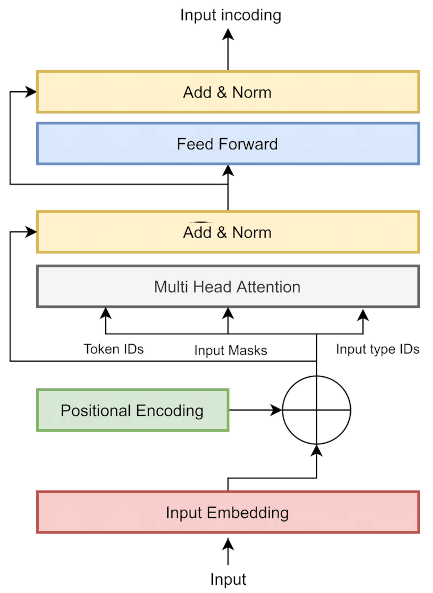

*Note*: [CLS] stands for classification. It is added at the beginning because the training tasks here is sentence classification. And because they need an input that can represent the meaning of the entire sentence!

In [ ]:
#@title Baseline architecture

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # linear projections for queries, keys, and values
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, attention_mask=None):
        batch_size, seq_length, embed_dim = x.size()

        # linear projection and split into q, k, v
        qkv = self.qkv_proj(x)
        qkv = qkv.view(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        q, k, v = qkv.chunk(3, dim=-1)

        # compute attention scores
        attn_scores = torch.einsum("bqhd,bkhd->bhqk", q, k) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            # apply the attention mask: add a large negative value to masked positions
            # explanation: maybe I'm apply an infinite negative number to not pay attention to that
            # vector that represents the dense embedding of id that are not meaningfull (so attention mask = 0)
            # print(f"attn_scores.shape -> {attn_scores.shape}")
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            attention_mask = attention_mask.expand(batch_size,num_heads,seq_length,seq_length)
            # print(f"attention_mask.shape -> {attention_mask.shape}")
            attn_scores = attn_scores.masked_fill(attention_mask == 0, float('-inf'))

        # einsum loop expantion just for analysis (do not uncomment)
        # for b in range(attn_weights.shape[0]):
        #     for q in range(attn_weights.shape[2]):
        #         for h in range(attn_weights.shape[1]):
        #             for d in range(v.shape[3]):
        #                 sum = 0
        #                 for k in range(v.shape[1]):
        #                     sum += attn_weights[b,h,q,k] * v[b,k,h,d]
        #                 print(sum)
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)

        # compute weighted values
        attn_output = torch.einsum("bhqk,bkhd->bqhd", attn_weights, v)
        attn_output = attn_output.contiguous().view(batch_size, seq_length, embed_dim)
        return self.out_proj(attn_output)


class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
        self.activation = nn.GELU()

    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))


class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()

        # multi-head attention and feed-forward layers
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.feed_forward = FeedForwardNetwork(embed_dim, ff_dim)

        # layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # dropout layer
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        # self-attention block with residual connection
        attn_output = self.self_attn(x, attention_mask=attention_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # feed-forward block with residual connection
        ff_output = self.feed_forward(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x


class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim
            ) for _ in range(num_layers)
        ])
        self.embedding = nn.Embedding(vocab_size, embed_dim) # 30522
        self.pos_encoder = PositionalEncoding(embed_dim)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return x


class SentimentAnalysisTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, num_classes=2, timing=False):
        super(SentimentAnalysisTransformer, self).__init__()

        # encoder + classification head: a simple linear layer for sentiment classification
        self.transformer_encoder = TransformerEncoder(vocab_size, embed_dim, num_heads, ff_dim, num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.set_timing = timing
        self.timing = []

    def forward(self, input_ids, attention_mask=None):

        start = time.time()
        encoder_output = self.transformer_encoder(input_ids, attention_mask=attention_mask)
        cls_token_output = encoder_output[:, 0, :]  # taking the output for the [CLS] token

        end = time.time()
        if self.set_timing:
            # print(f"encoding took {end - start:.4f} seconds")
            self.timing.append(end - start)
        # pass through the classifier head to get class logits
        return self.classifier(cls_token_output)


In [ ]:
#@title Baseline model

if already_load:
    print("removed old model to free up space")
    try:
        del model
        del optimizer
        del loss_fn
        torch.cuda.empty_cache()
    except:
        pass

# initialize the baseline model, loss function, and optimizer
model = SentimentAnalysisTransformer(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    num_classes=2,
    timing=timing
)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)


print("Baseline model loaded!")
print(model)
print(f"number of parameters: {sum(p.numel() for p in model.parameters()):_}")

removed old model to free up space
Baseline model loaded!
SentimentAnalysisTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiHeadSelfAttention(
          (qkv_proj): Linear(in_features=16, out_features=48, bias=True)
          (out_proj): Linear(in_features=16, out_features=16, bias=True)
        )
        (feed_forward): FeedForwardNetwork(
          (fc1): Linear(in_features=16, out_features=256, bias=True)
          (fc2): Linear(in_features=256, out_features=16, bias=True)
          (activation): GELU(approximate='none')
        )
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (embedding): Embedding(30522, 16)
    (pos_encoder): PositionalEncoding()
  )
  (classifier): Linea

In [ ]:
#@title Baseline training

baseline_loss_trend = []
train_model(
    model,
    train_dataloader,
    optimizer,
    loss_fn,
    epochs=5,
    device=device,
    set_mask=True,
    loss_trend=baseline_loss_trend,
    timing=timing
)

Training model...


  0%|          | 0/5 [00:00<?, ?it/s]

average time for batch 0.0049 seconds
epoch took 6.6081 seconds
average time for batch 0.0047 seconds
epoch took 6.6057 seconds
average time for batch 0.0047 seconds
epoch took 6.6038 seconds
average time for batch 0.0047 seconds
epoch took 6.4965 seconds
average time for batch 0.0047 seconds
epoch took 6.4333 seconds


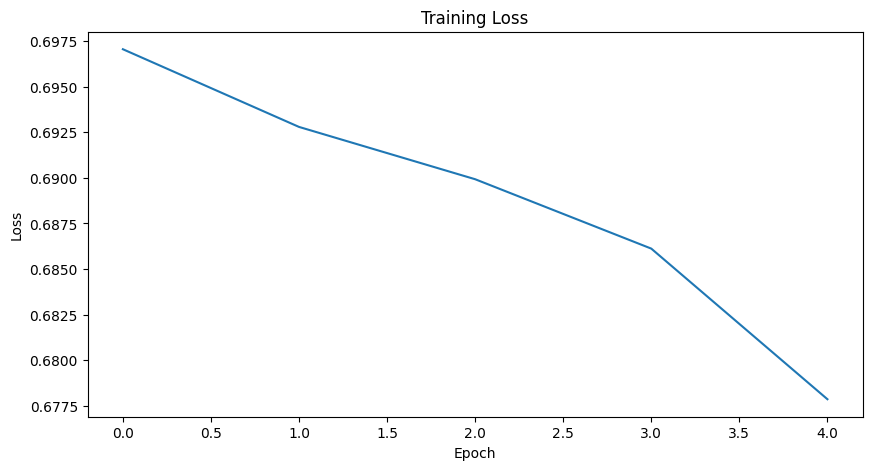

Evaluating model...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.6899983667961472
Accuracy: 0.5402
Precision: 0.605457142041188
Recall: 0.5402
F1-score: 0.45605070560269634

Confusion Matrix:



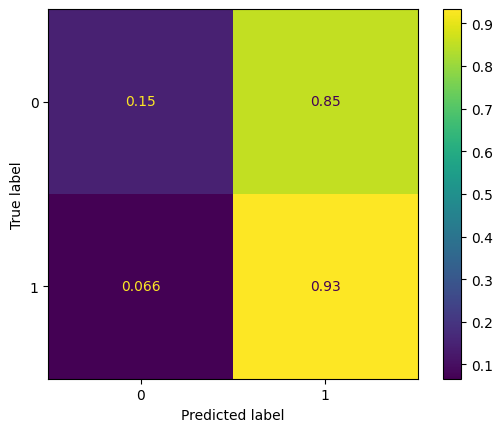

In [ ]:
#@title Baseline evaluation

# plot loss trend
plt.figure(figsize=(10, 5))
plt.plot(baseline_loss_trend)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

evaluation(model, test_dataloader,loss_fn, device=device, cm_plot=True)
torch.save(model.state_dict(), 'mvformer_model.pth')

# Clifford Modules


---


### Geometric Algebra
Geometric algebra is a mathematical framework that generalizes and extends linear algebra. It expands the concept of a vector into the more comprehensive concept of a multivector. Multivectors are generalized objects that can include scalars, vectors, and combinations of vectors, enabling the creation of new concepts that encapsulate more information. While a vector typically represents information such as length, position, and direction, a bivector, for example, represents oriented areas, and a trivector represents oriented volumes. This combination of elements allows for more complex geometric interpretations compared to simple vectors.

### Geometric Product
The geometric product is the main operation of geometric algebra. If we want to express this operation with respect to classical knowledge from linear algebra we can see that the geometric product combines dot product and cross product into a single operation. For 2 vectors a and b, the geometric product: ab=a⋅b+a∧b
where a⋅b is dot product, so produce a scalar, while the second a∧b is outer product, a generalization of cross product, that produce a bivector.





In [4]:
#@title Clifford algebra library

# clone clifford algebra repo
os.chdir('/content')
if not os.path.exists("./clifford-group-equivariant-neural-networks"):
    !git clone https://github.com/DavidRuhe/clifford-group-equivariant-neural-networks.git
os.chdir("clifford-group-equivariant-neural-networks")
from algebra.cliffordalgebra import CliffordAlgebra

algebra_dim = int(math.log(embed_dim, 2))
metric = [1 for i in range(algebra_dim)] # diag identity matrix for n-Dimentional geometric algebra

if not already_build:
    print("\nGenerating the algebra...")
    cl_algebra = CliffordAlgebra(metric)
    cl_algebra
    already_build = True
else:
    print("\nAlgebra already built!")

print(f"algebra dimention: \t {cl_algebra.dim}")
print(f"multivectors elements: \t {sum(cl_algebra.subspaces)}")
print(f"number of subspaces: \t {cl_algebra.n_subspaces}")
print(f"subspaces grades: \t {cl_algebra.grades.tolist()}")
print(f"subspaces dimentions: \t {cl_algebra.subspaces.tolist()}")
print("done")


Generating the algebra...
algebra dimention: 	 4
multivectors elements: 	 16
number of subspaces: 	 5
subspaces grades: 	 [0, 1, 2, 3, 4]
subspaces dimentions: 	 [1, 4, 6, 4, 1]
done


In [12]:
#@title Geometric algebra sandbox

if sandbox:
    print("sandbox mode")
    sandbox_dim = 2
    sandbox_metric = [1 for i in range(sandbox_dim)]

    sb_algebra = CliffordAlgebra(sandbox_metric)
    sb_algebra

    print(f"product paths: \n{sb_algebra.geometric_product_paths}")
    print(f"cayley: \n {sb_algebra.cayley}")

    x = torch.tensor(
        [[[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688,  0.7624]
    ]])
    print(x)
    print(x.shape)

    a = torch.tensor([ 1.9269,  1.4873,  0.9007, -2.1055])
    b = torch.tensor([ 0.6784, -1.2345, -0.0431, -1.6047])
    c = torch.tensor([-0.7521,  1.6487, -0.3925, -1.4036])
    d = torch.tensor([-0.7279, -0.5594, -0.7688,  0.7624])

    print("\nThe following three examples shows different methods to compute a self geometric product across all the multi vectiors in a give sequence\n")

    print("Unrolled loop version")
    print(sb_algebra.geometric_product(a,a))
    print(sb_algebra.geometric_product(a,b))
    print(sb_algebra.geometric_product(a,c))
    print(sb_algebra.geometric_product(a,d))
    print()
    print(sb_algebra.geometric_product(b,a))
    print(sb_algebra.geometric_product(b,b))
    print(sb_algebra.geometric_product(b,c))
    print(sb_algebra.geometric_product(b,d))
    print()
    print(sb_algebra.geometric_product(c,a))
    print(sb_algebra.geometric_product(c,b))
    print(sb_algebra.geometric_product(c,c))
    print(sb_algebra.geometric_product(c,d))
    print()
    print(sb_algebra.geometric_product(d,a))
    print(sb_algebra.geometric_product(d,b))
    print(sb_algebra.geometric_product(d,c))
    print(sb_algebra.geometric_product(d,d))
    print()

    print("Loop version")
    output = torch.zeros(1,4,4,4)
    for b in range(x.shape[0]):
        for m in range(x.shape[1]):
            for n in range(x.shape[1]):
                print(sb_algebra.geometric_product(x[b,m,:],x[b,n,:]))
                output[b,m,n, :] += sb_algebra.geometric_product(x[b,m,:], x[b,n,:])
            print()

    # print(output.shape)

    print("Vectorized version")
    mv = sb_algebra.geometric_product(x.unsqueeze(2), x.unsqueeze(1))
    print(mv)
    # print(mv.shape)

product paths: 
tensor([[[ True, False, False],
         [False,  True, False],
         [False, False,  True]],

        [[False,  True, False],
         [ True, False,  True],
         [False,  True, False]],

        [[False, False,  True],
         [False,  True, False],
         [ True, False, False]]])
cayley: 
 tensor([[[ 1.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  1.]],

        [[ 0.,  1.,  0.,  0.],
         [ 1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.],
         [ 0.,  0.,  1.,  0.]],

        [[ 0.,  0.,  1.,  0.],
         [ 0.,  0.,  0., -1.],
         [ 1.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.]],

        [[ 0.,  0.,  0., -1.],
         [ 0.,  0.,  1.,  0.],
         [ 0., -1.,  0.,  0.],
         [ 1.,  0.,  0.,  0.]]])
tensor([[[ 1.9269,  1.4873,  0.9007, -2.1055],
         [ 0.6784, -1.2345, -0.0431, -1.6047],
         [-0.7521,  1.6487, -0.3925, -1.4036],
         [-0.7279, -0.5594, -0.7688

In [ ]:
#@title Multivector linear layer

import opt_einsum as oe
class MVLinear(nn.Module):

    def __init__(self, algebra, in_features, out_features):
        super().__init__()

        self.algebra = algebra
        self.in_features = in_features
        self.out_features = out_features
        max_val = 600

        self.weight = nn.Parameter(
            torch.empty(self.out_features, self.in_features)
        )
        self.bias = nn.Parameter(torch.empty(1, 1, 1))
        self.b_dims = (0,)
        self.reset_parameters()
        # print(f"inside linear --> weight shape {self.weight.shape}")


    def reset_parameters(self):
        torch.nn.init.normal_(self.weight, std=1 / math.sqrt(self.in_features))

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def forward(self, input):
        # self.weight has shape [32, 256, 7]


        # Expand the weight tensor according to the subspaces
        # weight_expanded = self.weight.repeat_interleave(self.algebra.subspaces, dim=-1)
        # weight = self.weight.repeat_interleave(self.algebra.subspaces, dim=-1)

        output = torch.zeros(2, 4, 3, 4)
        custom = torch.zeros(2, 3, 4)
        # Element-wise multiplication
        # result = input * weight_expanded  # [32, 256, 64]
        weight = self.weight

        # print(f"inside linear --> x shape {input.shape}")
        # print(f"inside linear --> weight shape {weight.shape}")

        # result = torch.einsum("bm...i, nmi->bn...i", input, weight)
        # result = torch.einsum("bm...i, nmi->bn...i", input, self.weight)
        # start = time.time()
        # result = torch.einsum("bmi, nm->bmi", input, weight)
        # result = oe.contract_path("bmi, nm->bmi", input.detach().numpy(), self.weight.detach().numpy())
        result = torch.matmul(input, weight)
        # result = torch.einsum('ijk,kl->ijl', input, weight)
        # end = time.time()
        # print(f"operation took {end - start:.4f} seconds")


        # start = time.time()
        # for b in range(input.shape[0]): # batch size (b)
        #     for m in range(weight.shape[1]): # embed_dim  (d)
        #         for i in range(input.shape[-1]): # embed_dim (d)
        #             for n in range(weight.shape[0]): # seq len (s)
        #                 custom[b,m,i] += input[b,m,i] * weight[n,m]

                        #       b m i           n m
                        # input[0,0,0] * weight[0,0]
                        # input[0,1,0] * weight[1,0]
                        #             ...
                        # input[0,s,0] * weight[s,0]

                        # input[0,0,1] * weight[0,1]
                        # input[0,1,1] * weight[1,1]
                        #             ...
                        # input[0,s,1] * weight[s,1]

                        # input[0,0,d] * weight[0,d]
                        # input[0,1,d] * weight[1,d]
                        #             ...
                        # input[0,s,d] * weight[s,d]

                        # input[1,0,0] * weight[0,0]
        # end = time.time()
        # print(f"for loop took {end - start:.4f} seconds")
        bias = self.algebra.embed(self.bias, self.b_dims)
        # print(f"bias shape: {bias.shape}")
        # bias = self.bias[:input.shape[0], :input.shape[1], :]
        result = result + bias

        # print(f"result {result.shape}")

        return result



In [ ]:
#@title Normalization layer

EPS = 1e-6

class NormalizationLayer(nn.Module):

    def __init__(self, algebra, features, init: float = 0):
        super().__init__()
        self.algebra = algebra
        self.in_features = features
        max_seq = 1000

        # this parameter that learn how much to scale the input data
        # in particular the how much scale the norm of input (see forward)
        self.a = nn.Parameter(torch.zeros(max_seq, algebra.n_subspaces) + init)


    def forward(self, input):
        # debug
        # print(f"input before normalization {input.shape}")
        # print(f"in features {self.in_features}")
        # 0: is the batch size
        # 1: is the in_features for the input
        assert input.shape[2] == self.in_features

        # self.algebra.norms(input) compute norm for each subspace
        # print(f"shape of norms list elem: {self.algebra.norms(input)[0].shape}")
        norms = torch.cat(self.algebra.norms(input), dim=-1)
        s_a = torch.sigmoid(self.a)
        # print(f"s_a shape: {s_a[:input.shape[1], :].shape}")
        # print(f"norms shape: {norms.shape}")
        norms = s_a[:input.shape[1], :] * (norms - 1) + 1  # interpolates between 1 and the norm

        # when you see repeat_interleave usually means that
        # the same thing is repeated for each subspace
        norms = norms.repeat_interleave(self.algebra.subspaces, dim=-1)
        normalized = input / (norms + EPS)
        return normalized

In [ ]:
#@title FCSGPL (Optimized)

class FullyConnectedSteerableGeometricProductLayer(nn.Module):
    def __init__(
        self,
        algebra,
        features,
    ):
        super().__init__()
        self.algebra = algebra
        self.features = features

        self.normalization = NormalizationLayer(algebra, features)
        self.q_prj = MVLinear(algebra, features, features)
        self.k_prj = MVLinear(algebra, features, features)

    # @torch.jit.script
    def forward(self, input):
        batch, seq, dim = input.shape
        q = self.q_prj(input)
        k = self.k_prj(input)

        q = self.normalization(q)
        k = self.normalization(k)

        cayley = self.algebra.cayley.to(input.device) # [dim, dim, dim]
        q_einsum = q.unsqueeze(2)  # [batch, seq, 1, dim]
        k_einsum = k.unsqueeze(1)  # [batch, 1, seq, dim]

        # make tensor contigous in memory
        q_einsum = q_einsum.contiguous()
        k_einsum = k_einsum.contiguous()
        cayley = cayley.contiguous()

        q = q.half()
        k = k.half()
        cayley = cayley.half()

        # with autocast():
        #         output = torch.einsum("...i,ijk,...k->...j", q_einsum, cayley, k_einsum)

        with torch.amp.autocast('cuda'):
            output = fast_einsum(q_einsum, cayley, k_einsum)

        # monitor time on gpu
        # with torch.profiler.profile(
        #     activities=[
        #         torch.profiler.ProfilerActivity.CPU,
        #         torch.profiler.ProfilerActivity.CUDA,
        #     ],
        #     record_shapes=True
        # ) as prof:
        #     with torch.amp.autocast('cuda'):
        #         output = fast_einsum(q_einsum, cayley, k_einsum)
                # output = torch.einsum("...i,ijk,...k->...j", q_einsum, cayley, k_einsum)

                # Possible alterantive ???
                # # Compute q @ cayley using bmm
                # q_cayley = torch.bmm(q_einsum.view(-1, 1, dim), cayley.view(dim, dim*dim))  # [batch*seq, 1, dim*dim]
                # # Reshape and multiply with k
                # q_cayley = q_cayley.view(batch, seq, dim, dim)  # [batch, seq, dim, dim]
                # output = torch.bmm(q_cayley.view(batch * seq, dim, dim), k_einsum.view(-1, dim, 1))  # [batch*seq, dim, 1]
                # output = output.view(batch, seq, seq, dim)

        # print(prof.key_averages().table(sort_by="cuda_time_total"))

        # output = torch.zeros(batch, seq, seq, dim, device=input.device)
        # output = torch.zeros(input.shape[0], input.shape[1], input.shape[1], input.shape[-1]).to(input.device)
        # print(output.shape)
        # for b in range(input.shape[0]):
        #     for m in range(input.shape[1]):
        #         for n in range(input.shape[1]):
        #             output[b,m,n, :] += torch.einsum("...i,ijk,...k->...j", q[b,m,:], cayley, k[b,n,:])

        # Verify the shape
        # print(f"output shape: {output.shape}")

        return output

In [ ]:
#@title Attention Layer


class GeometricProductAttention(nn.Module):
    def __init__(self, algebra, embed_dim):
        """
        Self-Attention layer using geometric algebra.
        :param algebra: Geometric algebra object (assuming it is part of your setup)
        :param features: The number of features for the geometric product layer
        """
        super(GeometricProductAttention, self).__init__()

        self.algebra = algebra
        # Define the geometric product layer
        self.gp_layer = FullyConnectedSteerableGeometricProductLayer(algebra, embed_dim)

        # Define projection layers for each subspace
        self.subspaces_dims = algebra.subspaces
        # self.layers = nn.ModuleList([
        #     nn.Linear(self.subspaces_dims[_], 1) for _ in range(self.algebra.dim)
        # ])

        # single projection layer to learn common propertires
        self.att_prj = nn.Linear(embed_dim, 1)
        # regularization
        self.dropout = nn.Dropout(p=0.5)
        # self.att_prj = nn.Linear(algebra.dim, 1)

    def forward(self, x):
        """
        Perform self-attention using geometric algebra.
        :param x: Input tensor of shape (batch_size, 256, 512), where 512 is the multivector size.
        :return: Output tensor of shape (batch_size, 256, 256, 512) after self-attention.
        """

        start = time.time()
        # compute pairwise geometric products using the geometric product layer
        new_mv = self.gp_layer(x)
        # print(f"new mv shape {new_mv.shape}")

        # project multivector into a scalre space to obtain attention scores
        # tensor_list = []
        # i, j, k = 0, 1, 1
        # mv_chunks = copy.copy(new_mv)
        # for layer in self.layers:
        #     # print(f"controls i: {i}, j: {j}, k: {k}, ss: {self.subspaces_dims[k]}")
        #     # print(f"input shape {mv_chunks[:, :, i:j].shape}")
        #     # print(f"layer shape {layer}")
        #     new_mv = layer(mv_chunks[:, :, :, i:j])
        #     i = j
        #     j += int(self.subspaces_dims[k].item())
        #     k += 1
        #     # print(f"new multivector shape: {new_mv.shape}")
        #     tensor_list.append(new_mv)

        # result = torch.cat(tensor_list, dim=3)
        # print(f"result shape: {result.shape}")

        # apply attention score projection
        # output = self.att_prj(result)
        output = self.att_prj(new_mv.float())
        # print(output.shape)
        end = time.time()
        # print(f"attention score computation in {end - start:.4f} seconds")

        return output

# Multivectors Transformer (MVFormer)

---

### Proposed Architecture

**Initial Embedding** \\
The proposed architecture resembles a classic transformer encoder block with a fundamental modification to the self-attention function. Initially, the input IDs are converted into dense vectors with an embedding dimension equal to the length of the algebraic multivectors. Positional encoding values, based on sinusoidal summations, are then added to the embeddings.

**Multivector Embeddings** \\
These new embeddings are used to compute self-attention, where the inputs are treated as multivectors. The input is replicated as both a left and right input, and each multivector in both input sequences is weighted through an MVLinear layer. The output of these projections can be viewed as the query and key matrices in classical attention. The resulting shapes of Q and K are **[batch_size, sequence_len, sequence_len]**, equivalent to the original input shape.

**Geometric Product** \\
These two tensors are then combined through a custom implementation of the geometric product. This operation calculates the geometric product between each possible combination of multivectors in the input sequence. Since the geometric product between two multivectors generates a new multivector, the final shape of the output for this layer is **[batch_size, sequence_len, sequence_len, embedding_dim]** a batch of square matrices where each element is a multivector. To obtain the actual attention scores, all components of the multivectors are projected to a single scalar function through a fully connected layer. The purpose of this layer is to learn the weight of each multivector component, which, in the context of geometric algebra, has a specific meaning associated with the relative subspace it represents.

**Final Processing** \\
The final attention scores are multiplied by the value matrix, and the data flow through the network proceeds as in a classical transformer. A fully connected layer with a GELU activation function is then used for further processing. Finally, the encoding is passed to a linear layer for binary classification.

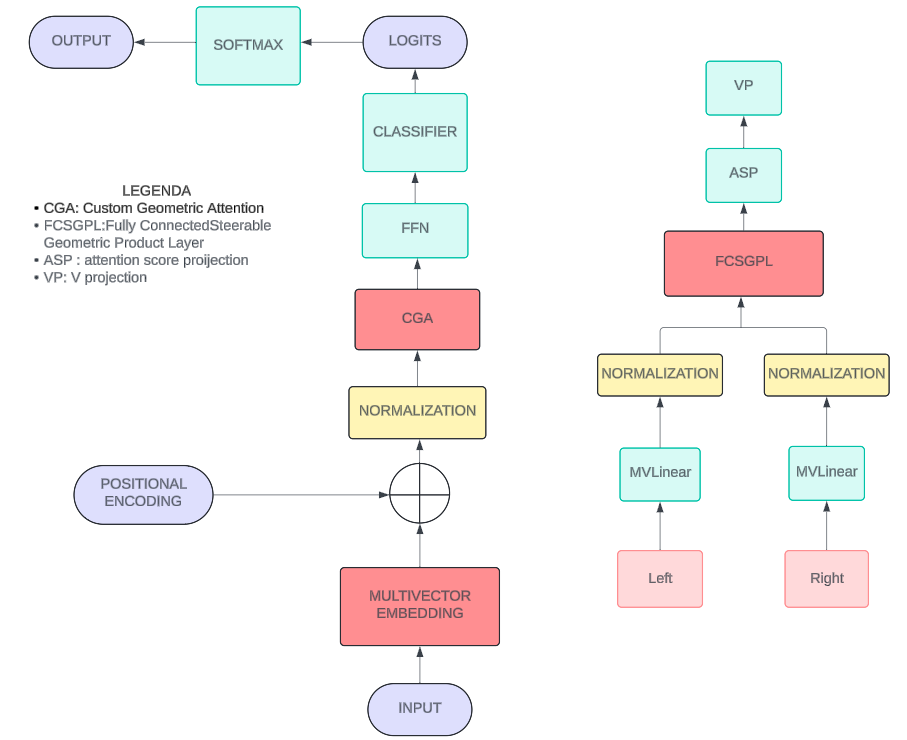

### Geometric Product Attention Idea
The idea behind geometric product attention is to combine the multivector embeddings of two given tokens into a new multivector that encapsulates relevant information about the relationships between the tokens. This relationship is captured not only through the dot product interaction between vector components but also by the geometric product combination of the multivector parts. The subspaces of a multivector represent oriented areas, volumes, and higher-dimensional pseudoscalars, which, according to our hypothesis, should encode the reciprocal influence of one word on another at a deeper level.


In [ ]:
#@title MVFormer architecture

class SelfAttentionGA(nn.Module):
    def __init__(self, algebra, embed_dim):
        super(SelfAttentionGA, self).__init__()

        self.algebra = algebra
        self.ga_attention = GeometricProductAttention(algebra, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, attention_mask=None):
        batch_size, seq_length, embed_dim = x.size()
        v = self.v_proj(x)

        # Compute attention scores using geometric product
        attn_scores = self.ga_attention(x).squeeze(-1)
        # print(f"attention scores shape {attn_scores.shape}")
        # print(f"attention score shape: {attn_scores.shape}")
        if attention_mask is not None:
            # Apply the attention mask: add a large negative value to masked positions
            attention_mask = attention_mask.unsqueeze(1)
            attention_mask = attention_mask.expand(batch_size,seq_length,seq_length)
            # print(f"attention_mask.shape -> {attention_mask.shape}")
            attn_scores = attn_scores.masked_fill(attention_mask == 0, float('-inf'))

        attn_probs = torch.softmax(attn_scores, dim=-1)

        # apply attention to values
        return torch.einsum("bqk,bvd->bqd", attn_probs, v)


class TransformerEncoderLayerGA(nn.Module):
    def __init__(self, algebra, embed_dim, hidden_dim):
        super(TransformerEncoderLayerGA, self).__init__()

        # feed forward network
        self.self_attn = SelfAttentionGA(algebra, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.fc_in = nn.Linear(embed_dim, hidden_dim)
        self.activation = nn.GELU()
        self.fc_out = nn.Linear(hidden_dim, embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, attention_mask=None):
        attn_out = self.self_attn(self.norm1(x), attention_mask)
        x = x + attn_out

        # feed-forward
        ff_out = self.fc_in(x)
        ff_out = self.activation(ff_out)
        ff_out = self.fc_out(ff_out)

        # residual and normalization
        x = x + ff_out
        x = self.norm2(x)
        # we are here yheeee!!!
        return x


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # create a long enough position tensor
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term[:pe[:, 1::2].shape[1]])
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # print(f"pe shape {self.pe.shape}")
        return x + self.pe[:, :x.size(1)]


class TransformerEncoderGA(nn.Module):
    def __init__(self, algebra, vocab_size, embed_dim, ff_dim, num_layers):
        super(TransformerEncoderGA, self).__init__()

        self.algebra = algebra
        self.layers = nn.ModuleList([
            TransformerEncoderLayerGA(
                algebra, embed_dim,ff_dim
            ) for _ in range(num_layers)
        ])
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)
        x = self.pos_encoder(x)

        for layer in self.layers:
            x = layer(x, attention_mask)
        return x


class SentimentAnalysisTransformerGA(nn.Module):
    def __init__(self, algebra, vocab_size, embed_dim, ff_dim, num_layers, num_classes=2, timing=False):
        super(SentimentAnalysisTransformerGA, self).__init__()

        self.cl_transformer_encoder = TransformerEncoderGA(
            algebra=algebra,
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            ff_dim=ff_dim,
            num_layers=num_layers
        )
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.set_timing = timing
        self.timing = []

    def forward(self, input_ids, attention_mask=None):
        start = time.time()
        encoder_output = self.cl_transformer_encoder(input_ids, attention_mask)
        cls_token_output = encoder_output[:,0,:]
        end = time.time()
        if self.set_timing:
            self.timing.append(end - start)
        logits = self.classifier(cls_token_output)
        return logits

In [ ]:
#@title MVFormer model

# initialize the model, loss function, and optimizer
if already_load:
    try:
        print("removing old model to free up space")
        del model
        del optimizer
        del loss_fn
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
    except:
        print("no model to delete")
        pass

model = SentimentAnalysisTransformerGA(
    algebra=cl_algebra,
    vocab_size=vocab_size, # 30522 (choosen by tokenizer used!)
    embed_dim=embed_dim,  # 512 --> 2**9 --> 9-dimentinal vector embedded into a multivector
    ff_dim=ff_dim,
    num_layers=num_layers,
    num_classes=2,
    timing=timing
)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

already_load = True
print("Multiovector Transformer loaded!")
print(model)
num_param = sum(p.numel() for p in model.parameters())
print(f"number of parameters: {num_param:_}")# {units[(num_param > 1000) + (num_param > 10000)]}")

removing old model to free up space
Multiovector Transformer loaded!
SentimentAnalysisTransformerGA(
  (cl_transformer_encoder): TransformerEncoderGA(
    (algebra): CliffordAlgebra()
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayerGA(
        (self_attn): SelfAttentionGA(
          (algebra): CliffordAlgebra()
          (ga_attention): GeometricProductAttention(
            (algebra): CliffordAlgebra()
            (gp_layer): FullyConnectedSteerableGeometricProductLayer(
              (algebra): CliffordAlgebra()
              (normalization): NormalizationLayer(
                (algebra): CliffordAlgebra()
              )
              (q_prj): MVLinear(
                (algebra): CliffordAlgebra()
              )
              (k_prj): MVLinear(
                (algebra): CliffordAlgebra()
              )
            )
            (att_prj): Linear(in_features=16, out_features=1, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
          )
          

In [ ]:
#@title MVFormer training

mvformer_loss_trend = []
train_model(
    model,
    train_dataloader,
    optimizer,
    loss_fn,
    epochs=5,
    device=device,
    # mem_step=20,
    set_mask=True,
    loss_trend=mvformer_loss_trend,
    timing=timing
)

Training model...


  0%|          | 0/5 [00:00<?, ?it/s]

average time for batch 0.0293 seconds
epoch took 23.8430 seconds
average time for batch 0.0293 seconds
epoch took 23.9763 seconds
average time for batch 0.0293 seconds
epoch took 23.7364 seconds
average time for batch 0.0292 seconds
epoch took 23.7392 seconds
average time for batch 0.0293 seconds
epoch took 23.9260 seconds


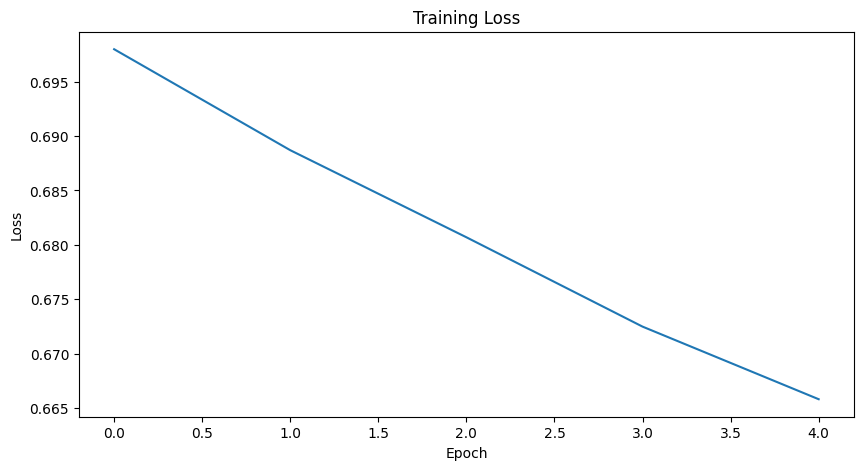

Evaluating model...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.6748564369843134
Accuracy: 0.59088
Precision: 0.5908927418535525
Recall: 0.59088
F1-score: 0.5908656613143127

Confusion Matrix:



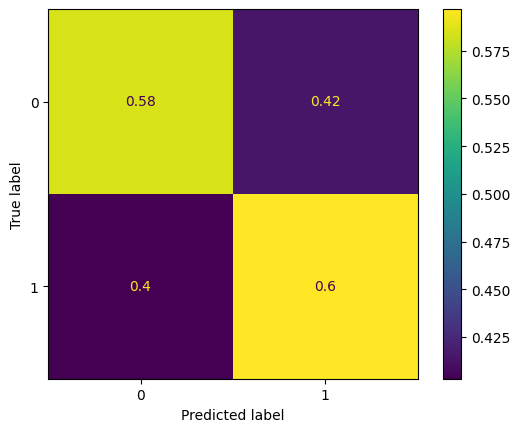

In [ ]:
#@title  MVFormer evaluation

# plot loss trend
plt.figure(figsize=(10, 5))
plt.plot(mvformer_loss_trend )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

evaluation(model, test_dataloader, loss_fn, device=device, cm_plot=True)
torch.save(model.state_dict(), 'mvformer_model.pth')

In [ ]:
#@title Free up GPU
try:
    del model
    del optimizer
    del loss_fn
except:
    print("no model to delete")
    pass
already_load = False

try:
    del input_ids
    del labels
    del logits
except:
    print("no data to delete")
    pass
gc.collect()
torch.cuda.empty_cache()
gc.collect()

no model to delete
no data to delete


0

# Conclusions


---
Here, we present the results of our experiments, which were conducted using low-dimensional embeddings, specifically 16-dimensional and 32-dimensional. Two main reasons support this decision:

1. The computational cost of the geometric product is quadratic in relation to the embedding dimensions, and the complexity of the embeddings increases exponentially with respect to the dimension of the algebra. \\

2. We aimed to evaluate the model's ability to produce meaningful embeddings, even if smaller, compared to a classic transformer. \\

The first reason is also related to the limited computational resources available, particularly in terms of VRAM. To address this issue, we employed various techniques to optimize the geometric product layer (see FCSGPL cell). However, this operation remains the bottleneck for our model’s performance, as evident in the execution times column of the results tables. Although our model is not well-suited for scaling with respect to the embedding dimensions, the results demonstrate higher overall metrics compared to the baseline under the same training conditions.


#### Results Table

| Model     | Algebra  | Embedding  | Accuracy  | Precision |  Recall  | F1-Score | Execution |
|-----------|----------|------------|-----------|-----------|----------|----------|-----------|
| Baseline  |    4     |    16      |   0.54    |   0.60    |   0.54   |   0.45   |   6.43s   |
| Baseline  |    5     |    32      |   0.62    |   0.62    |   0.62   |   0.62   |   6.49s   |
| MVFormer  |    4     |    16      |   0.59    |   0.59    |   0.59   |   0.59   |   23.9s   |
| MVFormer  |    5     |    32      |   0.62    |   0.63    |   0.62   |   0.62   |   26.0s   |



# References
[1] [Clifford Algebra](https://arxiv.org/pdf/2305.11141) \\
[2] [Geometric Clifford Algebra Networks](https://proceedings.mlr.press/v202/ruhe23a/ruhe23a.pdf) \\
[3] [Representing Words in a Geometric Algebra](https://www.pacm.princeton.edu/sites/default/files/pacm_arjunmani_0.pdf ) \\
[4] [From Complexity to Clarity](https://arxiv.org/pdf/2309.16512) \\
[5] [Geometric Algebra Transformer](https://https://arxiv.org/pdf/2305.18415)